# Imports #

## Libraries ##

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import MDS, Isomap, TSNE
from sklearn.cluster import KMeans, DBSCAN

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Dataset ##

In [2]:
data_df = pd.read_csv('Ressources' + '/' + 'TempData.csv')
data_df.drop(columns='Orders Made', inplace=True)
data_df

,Customer ID,Customer City,Last Order Date,Total Number of Orders,Average Number of Orders per Trimester,Number of Orders Last Trimester,Average Number of Items per Order,Total Payment,Average Payment per Trimester,Payment Last Trimester,Average Payment per Order,Average Payment Installments,Number of Different Product Categories,Percentage of Orders in the Same City,Number or Reviews Given,Percentage of Reviews Given,Average Time to Review (days),Average Score Given
0,861eff4711a542e4b93843c6dd7febb0,franca,736465.0,1.0,0.1,0.0,1.0,146.87,14.687,0.0,146.87,2.0,1.0,NaN,1.0,1.0,9.0,4.0
1,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,736706.0,1.0,0.1,0.0,1.0,335.48,33.548,0.0,335.48,8.0,1.0,NaN,1.0,1.0,17.0,5.0
2,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,736833.0,1.0,0.1,0.0,1.0,157.73,15.773,0.0,157.73,7.0,1.0,NaN,1.0,1.0,26.0,5.0
3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,736766.0,1.0,0.1,0.0,1.0,173.30,17.330,0.0,173.30,1.0,1.0,NaN,1.0,1.0,15.0,5.0
4,345ecd01c38d18a9036ed96c73b8d066,campinas,736904.0,1.0,0.1,0.0,1.0,252.25,25.225,0.0,252.25,8.0,1.0,NaN,1.0,1.0,11.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,sao paulo,736791.0,1.0,0.1,0.0,1.0,88.78,8.878,0.0,88.78,6.0,1.0,NaN,1.0,1.0,6.0,4.0
99437,d52a67c98be1cf6a5c84435bd38d095d,taboao da serra,736788.0,1.0,0.1,0.0,1.0,129.06,12.906,0.0,129.06,3.0,1.0,NaN,1.0,1.0,7.0,5.0
99438,e9f50caf99f032f0bf3c55141f019d99,fortaleza,736792.0,1.0,0.1,0.0,1.0,56.04,5.604,0.0,56.04,5.0,1.0,NaN,1.0,1.0,25.0,1.0
99439,73c2643a0a458b49f58cea58833b192e,canoas,736636.0,1.0,0.1,0.0,1.0,711.07,71.107,0.0,711.07,2.0,1.0,NaN,1.0,1.0,13.0,5.0


# Preprocessing the Data #

## Basic Informations ##

In [3]:
# Dataset Informations
print("Dataset's size : {}\n\nColumns' Names\n{}"
      .format(np.shape(data_df),[k for l,k in enumerate(data_df.columns)]))

Dataset's size : (99441, 18)

Columns' Names
['Customer ID', 'Customer City', 'Last Order Date', 'Total Number of Orders', 'Average Number of Orders per Trimester', 'Number of Orders Last Trimester', 'Average Number of Items per Order', 'Total Payment', 'Average Payment per Trimester', 'Payment Last Trimester', 'Average Payment per Order', 'Average Payment Installments', 'Number of Different Product Categories', 'Percentage of Orders in the Same City', 'Number or Reviews Given', 'Percentage of Reviews Given', 'Average Time to Review (days)', 'Average Score Given']


## Initializing Variables ##

In [4]:
numerical_columns = ['Last Order Date', 
                     'Total Number of Orders', 
                     'Average Number of Orders per Trimester', 
                     'Number of Orders Last Trimester', 
                     'Average Number of Items per Order', 
                     'Total Payment', 
                     'Average Payment per Trimester', 
                     'Payment Last Trimester', 
                     'Average Payment per Order', 
                     'Average Payment Installments', 
                     'Number of Different Product Categories', 
                     'Percentage of Orders in the Same City', 
                     'Number or Reviews Given', 
                     'Percentage of Reviews Given', 
                     'Average Time to Review (days)', 
                     'Average Score Given']

## Pipelines ##

We will first define some pipelines used for the preprocessing. Here, we will transform the strings in numbers and rescale the numerical variables.

In [5]:
ID_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)),
    ('scaler', RobustScaler(with_centering=False))
])
city_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', RobustScaler(with_centering=False))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', RobustScaler())
])
preprocessing = ColumnTransformer(
    [('ID', ID_pipe, ['Customer ID']),
     ('city', city_pipe, ['Customer City']),
     ('num', numerical_pipe, numerical_columns),
    ])

## Preprocessing in itself ##

In [6]:
X = data_df
X = preprocessing.fit_transform(X)

# Reducing the Data #

We will now look into reducing the data to be able to visualise it and to simplify the segmentation. We will try several methods of reduction to see what work the best.

## PCA ##

We will first try with a PCA since it is one of the most common dimension reduction tool.

In [26]:
X_dense = X.toarray()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

print('Percentage of variance explained by each component : \n{}\n'.format(pca.explained_variance_ratio_))
print('Sum of it:\n{}'.format(pca.explained_variance_ratio_.sum()))

Percentage of variance explained by each component : 
[0.92464183 0.04765526]

Sum of it:
0.972297085457244


## Truncated SVD ##

We then chose the truncated SVD because our data is composed of a sparse matrix, which isn't handled by PCA.

In [47]:
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit(X)

print('Percentage of variance explained by each component : \n{}\n'.format(svd.explained_variance_ratio_))
print('Sum of it:\n{}'.format(svd.explained_variance_ratio_.sum()))

Percentage of variance explained by each component : 
[0.92431103 0.04751452]

Sum of it:
0.9718255432992556


## MDS ##

In [57]:
mds = MDS(n_components=2)
X_mds = mds.fit(X_dense)

print('Percentage of variance explained by each component : \n{}\n'.format(mds.explained_variance_ratio_))
print('Sum of it:\n{}'.format(mds.explained_variance_ratio_.sum()))

MemoryError: Unable to allocate 73.7 GiB for an array with shape (99441, 99441) and data type float64

## Isomap ##

In [63]:
iso = Isomap(n_components=2)
X_isomap = iso.fit(X_dense)

print('Percentage of variance explained by each component : \n{}\n'.format(iso.explained_variance_ratio_))
print('Sum of it:\n{}'.format(iso.explained_variance_ratio_.sum()))

MemoryError: Unable to allocate 73.7 GiB for an array with shape (99441, 99441) and data type float64

## t-SNE ##

In [33]:
tsne = TSNE(n_components=2, perplexity=300, n_iter=600, init='pca')
X_tsne = tsne.fit(X_dense)

In [29]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(111)

    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 2e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            props={ 'boxstyle':'round', 'edgecolor':'white'}
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=plt.cm.gray, zoom=0.5), X[i], bboxprops=props)
            ax.add_artist(imagebox)
    if title is not None:
        plt.title(title)

In [34]:
plot_embedding(X_tsne, "ghirweofhwop")

TypeError: unsupported operand type(s) for -: 'TSNE' and 'TSNE'

# Testing Differents Unspervised Algorithms #

## K-Means ##

### Testing ###

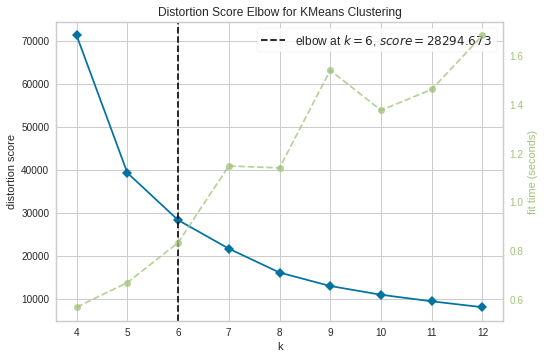

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(X_pca)
visualizer.poof()

Number of Clusters : 6



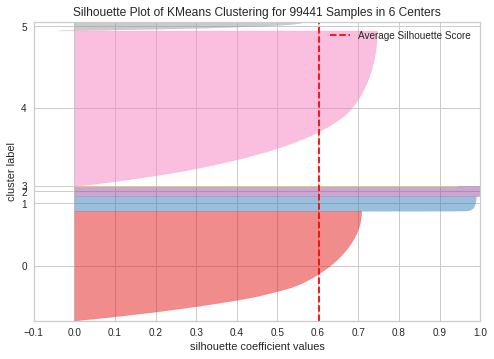

Number of Clusters : 7



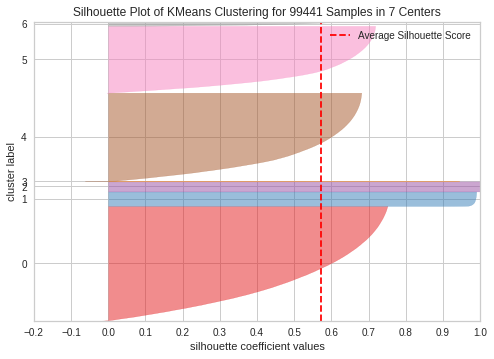

In [32]:
for i in range(6,8):
    print('Number of Clusters : {}\n'.format(i))
    model = KMeans(i)
    visualizer = SilhouetteVisualizer(model)
    
    visualizer.fit(X_pca)
    visualizer.poof()

### Setting Up ###

### Evaluating ###

## DBSCAN ##

### Testing ###

### Setting Up ###

### Evaluating ###